In [1]:
# Load the data from the floats.csv file
import pandas # https://pandas.pydata.org/
dataset = pandas.read_csv('floats.csv') 
dataset = dataset.dropna()  

# Set up the same prediction problem as before: 
X_name = [ 'Depth', 'Temperature', 'Salinity' ] 
X = dataset[X_name]   
y_name = 'callSign'   
y = dataset[y_name]   

print('done \n')

done 



In [2]:
# And set up our standard assessment framework:

# Set the random number seed before each run to ensure that the evaluation of each algorithm is performed using exactly the same data splits. 
# This ensures the results are directly comparable.
seed = 42          # setting the seed means that the same points will be split off every time we run this notebook - this allows for repeatability/reproducibility

# We partition our data into two parts: formative and summative 
from sklearn import model_selection 
test_pct = 0.20   # reserve a random 20% of the data points for summative evaluation in the end
X_formative, X_summative, y_formative, y_summative = model_selection.train_test_split(X, y, test_size=test_pct, random_state=seed)

# Now we create k stratified folds in the FORMATIVE data and reserve the SUMMATIVE split for the very end
k4folds = 5  
skfold = model_selection.StratifiedKFold(n_splits=5, random_state=seed, shuffle=True) 

# Choose the scoring method
scoring_method = 'f1_micro'

# Choose the tuning method
from sklearn.model_selection import GridSearchCV

print('done \n')

done 



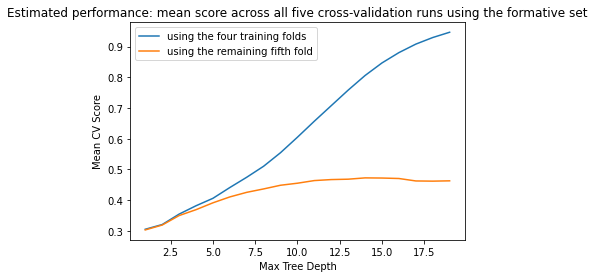

DecisionTreeClassifier(max_depth=14)

In [7]:
# Time to chose a model
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=seed)

# specify the versions of the family members
max_dep = range(1,20)  
hyperparameters = {'max_depth': max_dep }    

# train and validate all the family members together
modelFamily = GridSearchCV(DecisionTreeClassifier(), hyperparameters, cv=skfold, scoring=scoring_method, return_train_score=True)
modelFamily.fit(X_formative, y_formative)  

training_estimates = modelFamily.cv_results_['mean_train_score'] 
# this score is computed on the four training folds of X_formative, 
# and then averaged aCROSS all five VALIDATION runs

testing_estimates = modelFamily.cv_results_['mean_test_score']   
# this score is computed on the testing fold of X_formative (the remaining fifth one), 
# and then averaged aCROSS all the VALIDATION runs

# Plot the results
import matplotlib.pyplot as pl  # https://matplotlib.org/
pl.plot( max_dep,training_estimates, label='using the four training folds' )
pl.plot( max_dep,testing_estimates, label='using the remaining fifth fold' )
pl.ylabel('Mean CV Score')
pl.xlabel('Max Tree Depth')
pl.legend()
pl.title('Estimated performance: mean score across all five cross-validation runs using the formative set')
pl.show()

# Now we retrain the best looking candidate using ALL of the training data
best_looking_candidate = modelFamily.best_estimator_ 
best_looking_candidate.fit(X_formative, y_formative)

 ++++ Detailed classification report for the selected model ++++ 
Best candidate model version from GridSearchCV is DecisionTreeClassifier(max_depth=9) 
This model was trained and tuned on the formative split of the data using CV.
The following results are computed on the separate summative split of the data:

 clasification report:
               precision    recall  f1-score   support

    Q4901043       0.70      0.83      0.76       179
    Q4901044       0.65      0.88      0.75       573
    Q4901265       0.28      0.37      0.32       172
    Q4901266       0.24      0.17      0.20       195
    Q4901267       0.32      0.33      0.32       167
    Q4901268       0.28      0.27      0.27       132
    Q4901269       0.22      0.14      0.17       191
    Q4901270       0.22      0.15      0.18       190
    Q4901271       0.26      0.11      0.15        92
    Q4901272       0.19      0.11      0.14       103
    Q4901273       0.00      0.00      0.00        11

    accuracy  

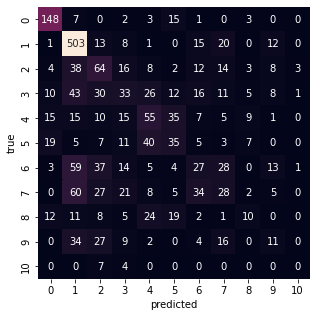

In [6]:
# Evaluate this retrained model on the summative split and summarize the results 
# as a final confusion matrix and a classification report
y_predicted = best_looking_candidate.predict(X_summative)

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns # https://seaborn.pydata.org/
print(" ++++ Detailed classification report for the selected model ++++ " )
print("Best candidate model version from GridSearchCV is %s " % best_looking_candidate)
print("This model was trained and tuned on the formative split of the data using CV.")
print("The following results are computed on the separate summative split of the data:")
print('\n clasification report:\n', classification_report(y_summative, y_predicted))  
pl.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix(y_summative, y_predicted), square=True, annot=True, fmt='d', cbar=False)
pl.xlabel('predicted')
pl.ylabel('true')
pl.show()